In [1]:
%matplotlib inline

In [2]:
from datetime import datetime
import os
from os.path import dirname, abspath, join
from os import getcwd
import sys

In [3]:
import random
import string
import pandas as pd
import numpy as np

In [4]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [5]:
import torch
import socket
from IPython.display import clear_output

In [6]:
# seed_arg = int(sys.argv[1])
# print ("\n\nSeed ARG: ",seed_arg)
seed_arg = 1

In [7]:
seedlist = np.array([161, 314, 228, 271828, 230, 4271031, 5526538, 6610165, 9849252, 34534, 73422, 8765])
seed = seedlist[seed_arg]
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

In [8]:
RNDM_STRING = ''.join(random.choices(string.ascii_uppercase + string.digits, k=8))# + datetime.now().strftime("_%H_%M_%S")
print("ID: ",RNDM_STRING)

ID:  HEAWIHTQ


In [9]:
class ENO(object):
    
    #no. of forecast types is 6 ranging from 0 to 5
  
    def __init__(self, location='tokyo', year=2010, shuffle=False, day_balance=False):
        self.location = location
        self.year = year
        self.day = None
        self.hr = None
        
        self.shuffle = shuffle
        self.day_balance = day_balance

        self.TIME_STEPS = None #no. of time steps in one episode
        self.NO_OF_DAYS = None #no. of days in one year
        
        self.NO_OF_DAYTYPE = 10 #no. of daytypes
        self.daycounter = 0 #to count number of days that have been passed
        
        self.sradiation = None #matrix with GSR for the entire year
        self.senergy = None #matrix with harvested energy data for the entire year
        self.fforecast = None #array with forecast values for each day
        

        self.henergy = None #harvested energy variable
        self.fcast = None #forecast variable
        self.sorted_days = [] #days sorted according to day type
        
        self.SMAX = 1000 # 1 Watt Solar Panel

    
    #function to get the solar data for the given location and year and prep it
    def get_data(self):
        #solar_data/CSV files contain the values of GSR (Global Solar Radiation in MegaJoules per meters squared per hour)
        #weather_data/CSV files contain the weather summary from 06:00 to 18:00 and 18:00 to 06:00+1
        location = self.location
        year = self.year

        THIS_DIR = getcwd()
        SDATA_DIR = abspath(join(THIS_DIR, 'solar_data'))  #abspath(join(THIS_DIR, '../../..', 'data'))
        
        sfile = SDATA_DIR + '/' + location +'/' + str(year) + '.csv'
        
        #skiprows=4 to remove unnecessary title texts
        #usecols=4 to read only the Global Solar Radiation (GSR) values
        solar_radiation = pd.read_csv(sfile, skiprows=4, encoding='shift_jisx0213', usecols=[4])
      
        #convert dataframe to numpy array
        solar_radiation = solar_radiation.values

        #convert missing data in CSV files to zero
        solar_radiation[np.isnan(solar_radiation)] = 0

        #reshape solar_radiation into no_of_daysx24 array
        solar_radiation = solar_radiation.reshape(-1,24)

        if(self.shuffle): #if class instatiation calls for shuffling the day order. Required when learning
            np.random.shuffle(solar_radiation) 
        self.sradiation = solar_radiation
        
        #GSR values (in MJ/sq.mts per hour) need to be expressed in mW
        # Conversion is accomplished by 
        # solar_energy = GSR(in MJ/m2/hr) * 1e6 * size of solar cell * efficiency of solar cell /(60x60) *1000 (to express in mW)
        # the factor of 2 in the end is assuming two solar cells
        self.senergy = 2*self.sradiation * 1e6 * (55e-3 * 70e-3) * 0.15 * 1000/(60*60)

        return 0
    
    #function to map total day radiation into type of day ranging from 0 to 5
    #the classification into day types is quite arbitrary. There is no solid logic behind this type of classification.
    
    def get_day_state(self,tot_day_radiation):
        bin_edges = np.array([0, 3.5, 6.5, 9.0, 12.5, 15.5, 18.5, 22.0, 25, 28])
        for k in np.arange(1,bin_edges.size):
            if (bin_edges[k-1] <= tot_day_radiation <= bin_edges[k]):
                day_state = k -1
                break
            else:
                day_state = bin_edges.size - 1
        return int(day_state)
    
    def get_forecast(self):
        #create a perfect forecaster.
        tot_day_radiation = np.sum(self.sradiation, axis=1) #contains total solar radiation for each day
        get_day_state = np.vectorize(self.get_day_state)
        self.fforecast = get_day_state(tot_day_radiation)
        
        #sort days depending on the type of day and shuffle them; maybe required when learning
        for fcast in range(0,6):
            fcast_days = ([i for i,x in enumerate(self.fforecast) if x == fcast])
            np.random.shuffle(fcast_days)
            self.sorted_days.append(fcast_days)
        return 0
    
    def reset(self,day=0): #it is possible to reset to the beginning of a certain day
        
        self.get_data() #first get data for the given year
        self.get_forecast() #calculate the forecast
        
        self.TIME_STEPS = self.senergy.shape[1]
        self.NO_OF_DAYS = self.senergy.shape[0]
        
        self.day = day
        self.hr = 0
        
        self.henergy = self.senergy[self.day][self.hr]
        self.fcast = self.fforecast[self.day]
        
        end_of_day = False
        end_of_year = False
        return [self.henergy, self.fcast, end_of_day, end_of_year]

    
    def step(self):
        end_of_day = False
        end_of_year = False
        if not(self.day_balance): #if daytype balance is not required
            if(self.hr < self.TIME_STEPS - 1):
                self.hr += 1
                self.henergy = self.senergy[self.day][self.hr] 
                self.fcast = self.fforecast[self.day]
            else:
                if(self.day < self.NO_OF_DAYS -1):
                    end_of_day = True
                    self.hr = 0
                    self.day += 1
                    self.henergy = self.senergy[self.day][self.hr] 
                    self.fcast = self.fforecast[self.day]
                else:
                    end_of_day = True
                    end_of_year = True
                    
        else: #when training, we want all daytypes to be equally represented for robust policy
              #obviously, the days are going to be in random order
            if(self.hr < self.TIME_STEPS - 1):
                self.hr += 1
                self.henergy = self.senergy[self.day][self.hr]
                self.fcast = self.fforecast[self.day]
            else:
                if(self.daycounter < self.NO_OF_DAYS -1):
                    end_of_day = True
                    self.daycounter += 1
                    self.hr = 0
                    daytype = random.choice(np.arange(0,self.NO_OF_DAYTYPE)) #choose random daytype
                    self.day = np.random.choice(self.sorted_days[daytype]) #choose random day from that daytype
                    self.henergy = self.senergy[self.day][self.hr] 
                    self.fcast = self.fforecast[self.day]
                else: 
                    end_of_day = True
                    end_of_year = True
                    self.daycounter = 0
        
        return [self.henergy, self.fcast, end_of_day, end_of_year]

In [10]:
class CAPM (object):
    def __init__(self,location='tokyo', year=2010, shuffle=False, trainmode=False):

        #all energy values i.e. BMIN, BMAX, BOPT, HMAX are in mWhr. Assuming one timestep is one hour
        
        self.BMIN = 0.0                #Minimum battery level that is tolerated. Maybe non-zero also
        self.BMAX = 10000.0            #Max Battery Level. May not necessarily be equal to total batter capacity [3.6V x 2500mAh]
        self.BOPT = 0.5 * self.BMAX    #Optimal Battery Level. Assuming 50% of battery is the optimum
        self.BLIM_LO = 0.15*self.BMAX
        self.BLIM_HI = 0.85*self.BMAX
        self.BSAFE_LO = 0.35*self.BMAX
        self.BSAFE_HI = 0.65*self.BMAX
        
        self.ENP_MARGIN = 0.3*self.BMAX

        
        self.HMIN = 0      #Minimum energy that can be harvested by the solar panel.
        self.HMAX = None   #Maximum energy that can be harvested by the solar panel. [500mW]
        
        self.DMAX = 500      #Maximum energy that can be consumed by the node in one time step. [~ 3.6V x 135mA]
        self.N_ACTIONS = 10  #No. of different duty cycles possible
        self.DMIN = self.DMAX/self.N_ACTIONS #Minimum energy that can be consumed by the node in one time step. [~ 3.6V x 15mA]
        
        self.binit = None     #battery at the beginning of day
        self.btrack = []      #track the battery level for each day
        self.v_btrack = []      #track the virtual battery level for each day

        self.atrack = []      #track the duty cycles for each day
        self.htrack = []      #track the harvested for each day
        self.batt = None      #battery variable
        self.enp = None       #enp at end of hr
        self.henergy = None   #harvested energy variable
        self.fcast = None     #forecast variable
        
        self.MUBATT = 0.6
        self.SDBATT = 0.02
        
        self.MUHENERGY = 0.5
        self.SDHENERGY = 0.2
        
        self.MUENP = 0
        self.SDENP = 0.02
        
        self.location  = location
        self.year      = year
        self.shuffle   = shuffle
        self.trainmode = trainmode
        self.eno       = None
        
        self.day_violation_flag = False
        self.violation_flag     = False
        self.violation_counter  = 0
        self.batt_full_counter  = 0
        self.batt_empty_counter = 0
        
        self.batt_violations    = 0

        self.NO_OF_DAYTYPE      = 10 #no. of daytypes
 
    def reset(self,day=0,batt=-1):
        henergy, fcast, day_end, year_end = self.eno.reset(day) #reset the eno environment
        self.violation_flag = False
        self.violation_counter = 0
        self.batt_violations = 0
        
        if(batt == -1):
            self.batt = self.BOPT
        else:
            self.batt = batt
            
        self.batt = np.clip(self.batt, self.BMIN, self.BMAX)
        self.binit = self.batt
        self.btrack = np.append(self.btrack, self.batt) #track battery levels
        self.v_btrack = np.append(self.v_btrack, self.batt) #track battery levels
#         self.enp = self.BOPT - self.batt
        self.enp = self.binit - self.batt #enp is calculated
        self.henergy = np.clip(henergy, self.HMIN, self.HMAX) #clip henergy within HMIN and HMAX
        self.fcast = fcast
        
        norm_batt    = self.batt    /self.BMAX
        norm_enp     = self.enp     /self.BMAX
        norm_henergy = self.henergy /self.HMAX
        norm_fcast   = self.fcast   /(self.NO_OF_DAYTYPE-1)
        c_state = [norm_batt, norm_enp, norm_henergy, norm_fcast] #continuous states

        reward = 0
        
        return [c_state, reward, day_end, year_end]
    
    def getstate(self): #query the present state of the system
        norm_batt    = self.batt    /self.BMAX
        norm_enp     = self.enp     /self.BMAX
        norm_henergy = self.henergy /self.HMAX
        norm_fcast   = self.fcast   /(self.NO_OF_DAYTYPE-1)
        c_state = [norm_batt, norm_enp, norm_henergy, norm_fcast] #continuous states

        return c_state
        
    
    #reward function
    def rewardfn(self):
        violation_penalty = 0
        bmean = self.v_btrack.mean()
        bdev = self.BOPT - bmean
        if np.abs(bdev) > (self.BOPT - 0.25*self.BMAX):
            reward = 1.5-np.abs(bdev)/self.BMAX*5
        else:
            reward = 2
#         reward = 2 - 20*np.abs(bdev)/self.BMAX
        if(self.day_violation_flag):
            violation_penalty += 3    #penalty for violating battery limits anytime during the day
        return (reward - violation_penalty)
    
    
    
    def step(self, action):
        day_end = False
        year_end = False
        self.violation_flag = False
        reward = 0
        self.atrack = np.append(self.atrack, action+1) #track duty cycles
        self.htrack = np.append(self.htrack, self.henergy)

#         action_var = np.abs(np.mean(self.atrack) - action)/9 #can vary from 0 to 1
#         reward += 0.25*(0.5 - action_var ) #reward penalizing high duty cycle variance [-0.5 to 0.5]*0.25
      
        action = np.clip(action, 0, self.N_ACTIONS-1) #action values range from (0 to N_ACTIONS-1)
        e_consumed = (action+1)*self.DMAX/self.N_ACTIONS   #energy consumed by the node
        
        
        self.batt += (self.henergy - e_consumed)
        
        v_batt = self.binit + self.htrack.sum() - self.atrack.sum()*self.DMAX/self.N_ACTIONS
        self.v_btrack = np.append(self.v_btrack, v_batt) #track battery levels
        
        if(self.batt <= self.BMIN or self.batt >= self.BMAX ):
                self.batt_violations += 1
        
        if(self.batt <= self.BMIN or self.batt >= self.BMAX ):
#         if(self.batt < self.BLIM_LO or self.batt > self.BLIM_HI ):
            self.violation_flag = True #penalty for violating battery limits everytime it happens
#             reward -= 2
#             if(self.batt < self.BLIM_LO): #battery depletion is more fatal than battery overflow
#                 reward -= 2

        if(self.batt <= self.BMIN ): 
            self.batt_empty_counter += 1
        if(self.batt >= self.BMAX ): 
            self.batt_full_counter  += 1

        if(self.violation_flag):
            if(self.day_violation_flag == False): #penalty for violating battery limits anytime during the day - triggers once everyday
                self.violation_counter += 1
                self.day_violation_flag = True
                
        #calculate ENP before clipping
#         self.enp = self.BOPT - self.batt
        self.enp = self.binit - self.batt
        
        self.batt = np.clip(self.batt, self.BMIN, self.BMAX) #clip battery values within permitted level
        self.btrack = np.append(self.btrack, self.batt) #track battery levels
        
        
        #proceed to the next time step
       
        self.henergy, self.fcast, day_end, year_end = self.eno.step()
        self.henergy = np.clip(self.henergy, self.HMIN, self.HMAX) #clip henergy within HMIN and HMAX
                        
        if(day_end): #if eno object flags that the day has ended then give reward
            reward += self.rewardfn()
            if (self.trainmode): #reset battery to optimal level if limits are exceeded when training
#                 self.batt = np.random.uniform(self.DMAX*self.eno.TIME_STEPS/self.BMAX,0.8)*self.BMAX
#                 if (self.violation_flag):
                if np.random.uniform() < HELP : #occasionaly reset the battery
                    self.batt = self.BOPT  
            
            self.day_violation_flag = False
            self.binit = self.batt #this will be the new initial battery level for next day
            self.btrack = [] #clear battery tracker
            self.v_btrack = [] #clear battery tracker
            self.atrack = [] #clear duty cycle tracker
            self.htrack = [] #clear henergy tracker
   
        norm_batt    = self.batt    /self.BMAX
        norm_enp     = self.enp     /self.BMAX
        norm_henergy = self.henergy /self.HMAX
        norm_fcast   = self.fcast   /(self.NO_OF_DAYTYPE-1)
        c_state = [norm_batt, norm_enp, norm_henergy, norm_fcast] #continuous states
        
        return [c_state, reward, day_end, year_end]

In [11]:
LOCATION = 'tokyo'
NAME       = 'A0TOKYO_17_40_04'
MODELNAME  = NAME + '_' + str(seed) + '.pt'
print("\nMODEL : ", NAME)
print("SEED  : ",seed_arg)
print("HOST  : ",socket.gethostname())
print("START : ",datetime.now())


MODEL :  A0TOKYO_17_40_04
SEED  :  1
HOST  :  3d7e6ad341be
START :  2019-04-02 04:17:45.405889


In [12]:
# Hyper Parameters
BATCH_SIZE          = 32
WT_DECAY            = None
LR                  = 1e-4          # learning rate
EPSILON             = 0.9           # greedy policy
GAMMA               = 0.9           # reward discount
LAMBDA              = 0.95          # parameter decay
TARGET_REPLACE_ITER = 24*7*4*18     # target update frequency
MEMORY_CAPACITY     = 24*7*4*12*3   # store upto six month worth of memory   

N_ACTIONS           = 10            # no. of duty cycles (0,1,2,3,4)
N_STATES            = 4             # number of state space parameter [batt, enp, henergy, fcast]

HIDDEN_LAYER        = 50            # width of NN
NO_OF_ITERATIONS    = 100
GPU                 = False         # device
HELP                = 0.05

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

#Class definitions for NN model and learning algorithm
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.fc1 = nn.Linear(N_STATES, HIDDEN_LAYER)
        nn.init.kaiming_uniform_(self.fc1.weight)

        self.fc_out = nn.Linear(HIDDEN_LAYER, N_ACTIONS)
        nn.init.xavier_uniform_(self.fc_out.weight) 
    
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc_out(x)
        return x
    
class DQN(object):
    def __init__(self):
        if(GPU): 
            device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        else:
            device = torch.device('cpu')
        self.eval_net, self.target_net = Net(), Net()
        self.eval_net.to(device)
#         self.target_net.to(device)
        self.device = device
#         print("Neural net")
#         print(self.eval_net)
#         self.learn_step_counter = 0                                     # for target updating
#         self.memory_counter = 0                                         # for storing memory
#         self.memory = np.zeros((MEMORY_CAPACITY, N_STATES * 2 + 2))     # initialize memory [mem: ([s], a, r, [s_]) ]
# #         self.optimizer = torch.optim.RMSprop(self.eval_net.parameters(), lr=LR, alpha=0.95, eps=1e-2, weight_decay=0, momentum=0, centered=False)
#         self.optimizer = torch.optim.Adam(self.eval_net.parameters(), lr=LR)

#         self.running_loss = 0.0
        
        
# #         self.optimizer = torch.optim.Adam(self.eval_net.parameters(), lr=LR)
# #         self.optimizer = torch.optim.Adam(self.eval_net.parameters(), lr=LR, weight_decay=WT_DECAY)
# #         self.loss_func = nn.SmoothL1Loss()
#         self.loss_func = nn.MSELoss()
#         self.nettoggle = False
    def get_qvals(self,x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        actions_value = self.eval_net.forward(x)
        actions_value = actions_value.data.numpy()
        return actions_value
    
#     def choose_action(self, x):
#         x = torch.unsqueeze(torch.FloatTensor(x), 0)
#         x = x.to(self.device)

#         actions_value = self.eval_net.forward(x)
#         actions_value = actions_value.to(torch.device("cpu"))
#         action = torch.max(actions_value, 1)[1].data.numpy()
#         action = action[0] # return the argmax index
#         if np.random.uniform() > EPSILON:   # greedy
#             action += np.random.randint(-3, 3)
#             action = int(np.clip(action, 0, N_ACTIONS-1))
#         return action
    
#     def choose_greedy_action(self, x):
#         x = torch.unsqueeze(torch.FloatTensor(x), 0)
#         x = x.to(self.device)

#         # input only one sample
#         if True:   # greedy
#             actions_value = self.eval_net.forward(x)
#             actions_value = actions_value.to(torch.device("cpu"))
#             action = torch.max(actions_value, 1)[1].data.numpy()
#             action = action[0] # return the argmax index
#         return action

#     def store_transition(self, s, a, r, s_):
#         transition = np.hstack((s, [a, r], s_))
#         # replace the old memory with new memory
#         index = self.memory_counter % MEMORY_CAPACITY
#         self.memory[index, :] = transition
#         self.memory_counter += 1
    
#     def store_day_transition(self, transition_rec):
#         data = transition_rec
#         index = self.memory_counter % MEMORY_CAPACITY
#         self.memory= np.insert(self.memory, index, data,0)
#         self.memory_counter += transition_rec.shape[0]

#     def learn(self):
#         # target parameter update
#         if self.learn_step_counter % TARGET_REPLACE_ITER == 0:
#             self.target_net.load_state_dict(self.eval_net.state_dict())
#             self.nettoggle = not self.nettoggle
#         self.learn_step_counter += 1

#         # sample batch transitions
#         sample_index = np.random.choice(MEMORY_CAPACITY, BATCH_SIZE)
#         b_memory = self.memory[sample_index, :]
#         b_s = torch.FloatTensor(b_memory[:, :N_STATES])
#         b_a = torch.LongTensor(b_memory[:, N_STATES:N_STATES+1].astype(int))
#         b_r = torch.FloatTensor(b_memory[:, N_STATES+1:N_STATES+2])
#         b_s_ = torch.FloatTensor(b_memory[:, -N_STATES:])
        
#         b_s = b_s.to(self.device)
#         b_a = b_a.to(self.device)
#         b_r = b_r.to(self.device)
#         b_s_ = b_s_.to(self.device)

#         # q_eval w.r.t the action in experience
#         q_eval   = self.eval_net(b_s).gather(1, b_a)  # shape (batch, 1)
#         a_eval   = self.eval_net(b_s).max(1)[1].view(BATCH_SIZE, 1) #best action according to eval_net
#         q_next   = self.target_net(b_s_).detach()     # detach from graph, don't backpropagate
#         q_target = b_r + GAMMA * q_next.gather(1, a_eval)   # shape (batch, 1)
#         loss     = self.loss_func(q_eval, q_target)

#         self.optimizer.zero_grad()
#         loss.backward()
#         self.optimizer.step()
        
#         self.running_loss += loss.mean().item()
#         if self.learn_step_counter % TARGET_REPLACE_ITER == 0:
#             print('LOSS : %.3f' %(self.running_loss / TARGET_REPLACE_ITER))
#             self.running_loss = 0.0

In [14]:
def ndim_grid(start,stop, granularity):
    # Set number of dimensions
    ndims = len(start)

    # List of ranges across all dimensions
    L = [np.linspace(start[i],stop[i],granularity) for i in range(ndims)]

    # Finally use meshgrid to form all combinations corresponding to all 
    # dimensions and stack them as M x ndims array
    return np.hstack((np.meshgrid(*L))).swapaxes(0,1).reshape(ndims,-1).T

In [15]:
c_init      = CAPM()
c_init.eno  = ENO()
c_init.HMAX = c_init.eno.SMAX

In [16]:
# CONSTANTS
BMAX = c_init.BMAX
HMAX = c_init.HMAX

In [17]:
#DISCRETIZING LIMITS 

B_MAX = c_init.BMAX
B_MIN = 0

ENP_MAX =  c_init.BMAX
ENP_MIN = -c_init.BMAX

H_MAX =  c_init.HMAX
H_MIN =  0

F_MAX = c_init.NO_OF_DAYTYPE - 1
F_MIN = 0

GRANULARITY = 50
print("GRANULARITY: ", GRANULARITY)

#Discrete state borders
batt_s    = np.linspace(B_MIN, B_MAX, GRANULARITY)
enp_s     = np.linspace(ENP_MIN, ENP_MAX, GRANULARITY)
henergy_s = np.linspace(H_MIN, H_MAX, GRANULARITY)
fcast_s   = np.linspace(F_MIN, F_MAX, GRANULARITY)

GRANULARITY:  50


In [18]:
def normalize(s):
    normalizer = np.array([BMAX, BMAX, HMAX, F_MAX])
    return s/normalizer[None,:]        

In [19]:
def denormalize(s):
    normalizer = np.array([BMAX, BMAX, HMAX, F_MAX])
    return s*normalizer[None,:]    

In [20]:
def stdize(s):
    MU_BATT = 0.5
    SD_BATT = 0.5
    
    MU_ENP = 0
    SD_ENP = 0.5
    
    MU_HENERGY = 0.35
    SD_HENERGY = 0.55
    
    MU_FCAST = 0.5
    SD_FCAST = 0.6
     
    MU = np.array([MU_BATT, MU_ENP, MU_HENERGY, MU_FCAST])
    SD = np.array([SD_BATT, SD_ENP, SD_HENERGY, SD_FCAST])
        
    X = s - MU[None, :]
    return X/SD[None,:]

In [21]:
# def stdize(s):
#     MU_BATT = 0.5
#     SD_BATT = 0.15
    
#     MU_ENP = 0
#     SD_ENP = 0.15
    
#     MU_HENERGY = 0.35
#     SD_HENERGY = 0.25
    
#     MU_FCAST = 0.42
#     SD_FCAST = 0.27
    
#     norm_batt, norm_enp, norm_henergy, norm_fcast = s
    
#     std_batt    = (norm_batt    - MU_BATT    )/SD_BATT
#     std_enp     = (norm_enp     - MU_ENP     )/SD_ENP
#     std_henergy = (norm_henergy - MU_HENERGY )/SD_HENERGY
#     std_fcast   = (norm_fcast   - MU_FCAST   )/SD_FCAST

#     return [std_batt, std_enp, std_henergy, std_fcast]


In [22]:
def discretize(batt_val, enp_val, henergy_val, fcast_val):
    batt_indx    = np.where(batt_s    >= batt_val   )[0][0].astype(int)
    enp_indx     = np.where(enp_s     >= enp_val    )[0][0].astype(int)
    henergy_indx = np.where(henergy_s >= henergy_val)[0][0].astype(int)
    fcast_indx   = np.where(fcast_s   >= fcast_val  )[0][0].astype(int)
    return [batt_indx, enp_indx, henergy_indx, fcast_indx]

In [23]:
Q_TABLE = np.zeros((GRANULARITY,
                    GRANULARITY,
                    GRANULARITY,
                    GRANULARITY, 
                    N_ACTIONS))

Q_FILENAME = RNDM_STRING + "_Q_TABLE"
# np.save(Q_FILENAME, Q_TABLE)
# print("Q-TABLE FILENAME: ", Q_FILENAME,".npy")

state_combinations = ndim_grid( [B_MIN, ENP_MIN, H_MIN, F_MIN],
                                [B_MAX, ENP_MAX, H_MAX, F_MAX],
                                GRANULARITY)
norm_state_combinations = normalize(state_combinations)
std_state_combinations  = stdize(norm_state_combinations)

In [24]:
# Discretize NN Model
S_FILENAME = './models/'+ 'demo_' + MODELNAME
dqn = DQN()
dqn.eval_net.load_state_dict(torch.load(S_FILENAME))
dqn.eval_net.eval()
Q_TABLE = dqn.get_qvals(std_state_combinations).reshape(GRANULARITY,GRANULARITY,GRANULARITY,GRANULARITY,-1)
# np.save(Q_FILENAME,Q_TABLE)

In [25]:
YEAR = 2007



************************************
Anuual Average Reward    =   1.99
Day Violations           =      0
Battery Limit Violations =      0
Battery FULL Violations  =      0
Battery EMPTY Violations =      0


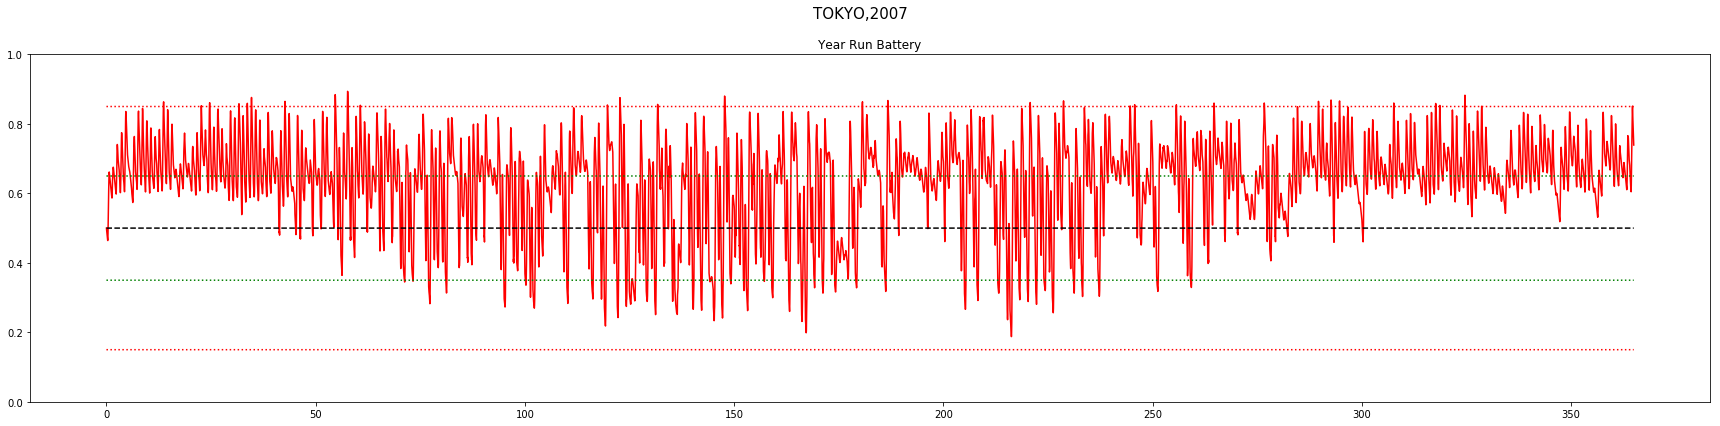

In [26]:
capm = CAPM(LOCATION,YEAR,shuffle=False, trainmode=False) #instantiate the CAPM class
capm.eno = ENO(LOCATION,YEAR, shuffle=False, day_balance=False) #instantiate the environment inside the CAPM class
capm.HMAX = capm.eno.SMAX #maximum power output of solar cell is set in CAPM object using the value in ENO object

s, r, day_end, year_end = capm.reset()
yr_test_record = np.empty(4)

while True:
    batt_val, enp_val, henergy_val, fcast_val = denormalize(s).flatten()
    discrete_s = discretize(batt_val, enp_val, henergy_val, fcast_val)
    
    a = Q_TABLE[tuple(discrete_s)].argmax()

    #state = [batt, enp, henergy, fcast]
    yr_test_record = np.vstack((yr_test_record, [s[0],s[2],r, a])) #record battery, henergy, reward and action

    # take action
    s_, r, day_end, year_end = capm.step(a)

    if year_end:
        break

    s = s_

yr_test_record = np.delete(yr_test_record, 0, 0) #remove the first row which is garbage
yr_test_reward_rec = yr_test_record[:,2]
yr_test_reward_rec = yr_test_reward_rec[::24]

print("\n\n************************************")
print("Anuual Average Reward    = {:6.2f}".format(np.mean(yr_test_reward_rec)))
print("Day Violations           = {:6d}".format(capm.violation_counter))
print("Battery Limit Violations = {:6d}".format(capm.batt_violations))
print("Battery FULL Violations  = {:6d}".format(capm.batt_full_counter))
print("Battery EMPTY Violations = {:6d}".format(capm.batt_empty_counter))

title = LOCATION.upper() + ',' + str(YEAR)
NO_OF_DAYS = capm.eno.NO_OF_DAYS

fig = plt.figure(figsize=(24,6))
fig.suptitle(title, fontsize=15)

#     ax1 = fig.add_subplot(211)
#     ax1.plot(yr_test_reward_rec)
#     ax1.set_title("\n\nYear Run Reward")
#     ax1.set_ylim([-3,3])

#Plot the reward and battery for the entire year run
ax2 = fig.add_subplot(111)
ax2.plot(yr_test_record[:,0],'r')
ax2.plot(np.ones_like(yr_test_record[:,0])*capm.BOPT/capm.BMAX, 'k--')
ax2.plot(np.ones_like(yr_test_record[:,0])*capm.BLIM_LO/capm.BMAX, 'r:')
ax2.plot(np.ones_like(yr_test_record[:,0])*capm.BLIM_HI/capm.BMAX, 'r:')
ax2.plot(np.ones_like(yr_test_record[:,0])*(capm.BOPT+capm.ENP_MARGIN /2) /capm.BMAX, 'g:')
ax2.plot(np.ones_like(yr_test_record[:,0])*(capm.BOPT-capm.ENP_MARGIN/2)/capm.BMAX, 'g:')
ax2.set_title("\n\nYear Run Battery")
ax2.set_ylim([0,1])
plt.sca(ax2)
plt.xticks(np.arange(0, NO_OF_DAYS*24, 50*24),np.arange(0,NO_OF_DAYS,50))
fig.tight_layout()
plt.show()

In [27]:
DAY_START = 260
DAY_END   = 280

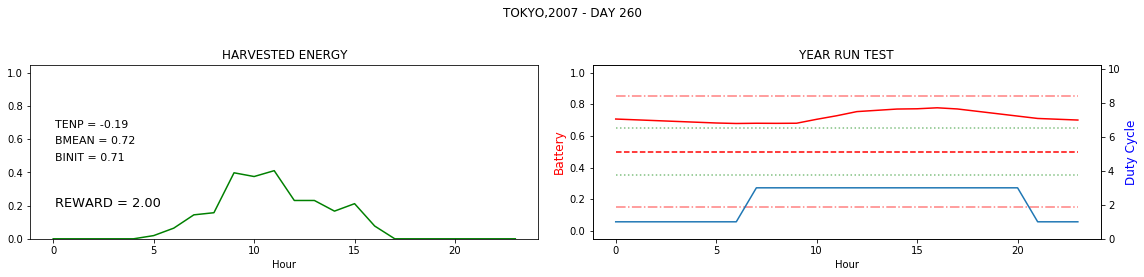

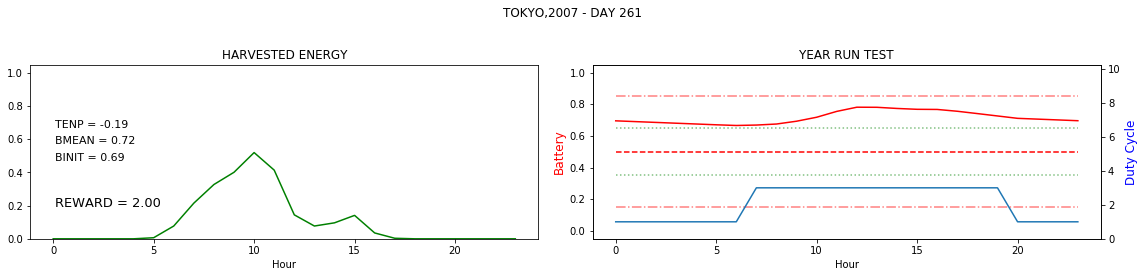

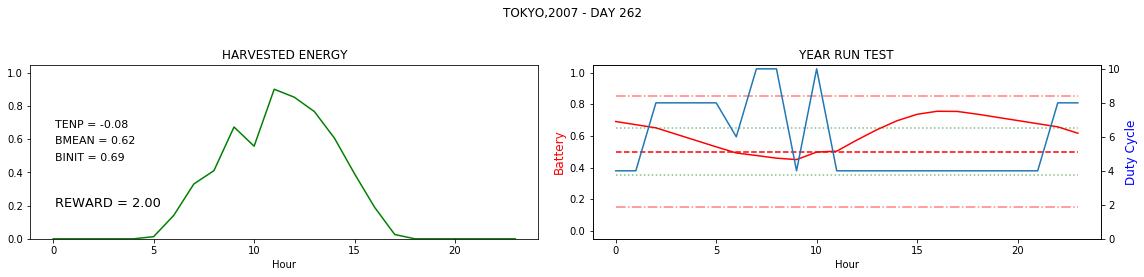

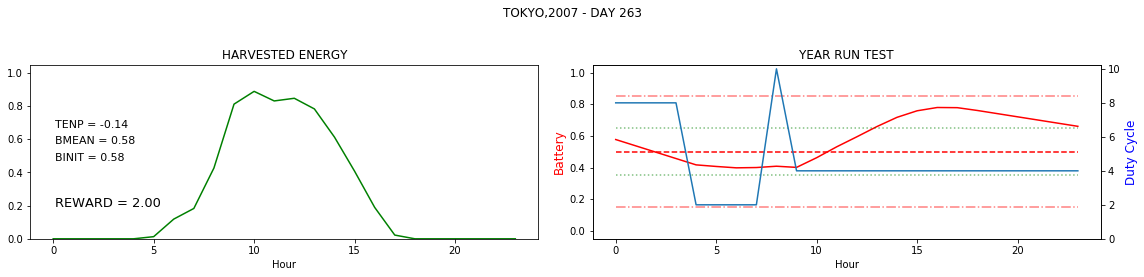

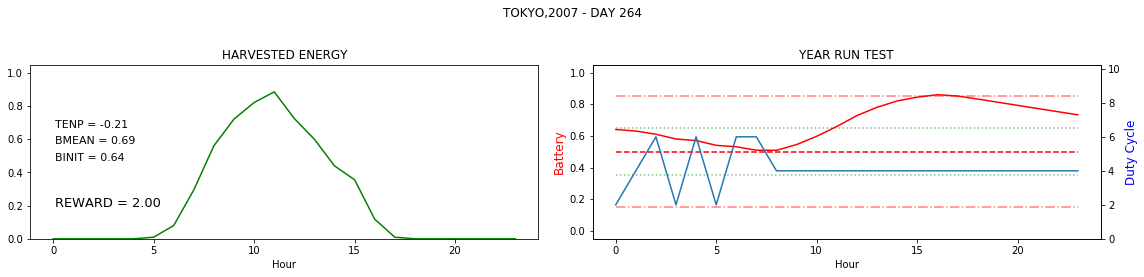

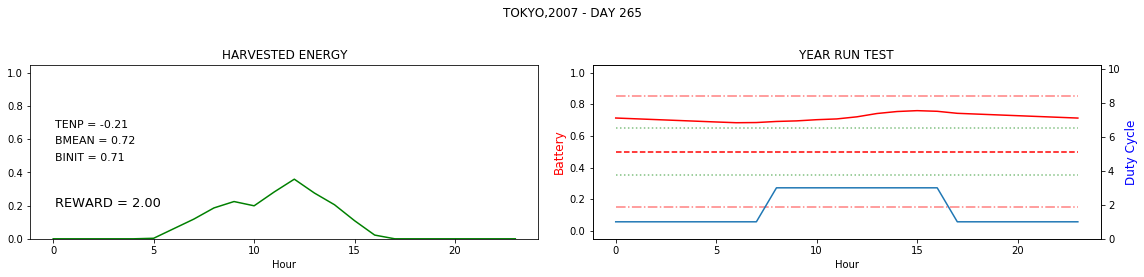

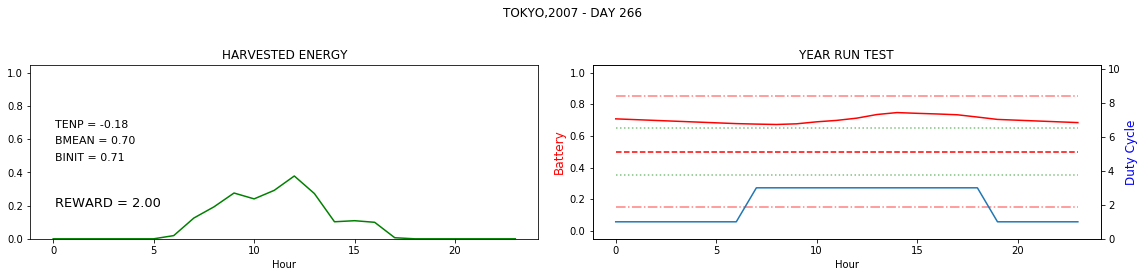

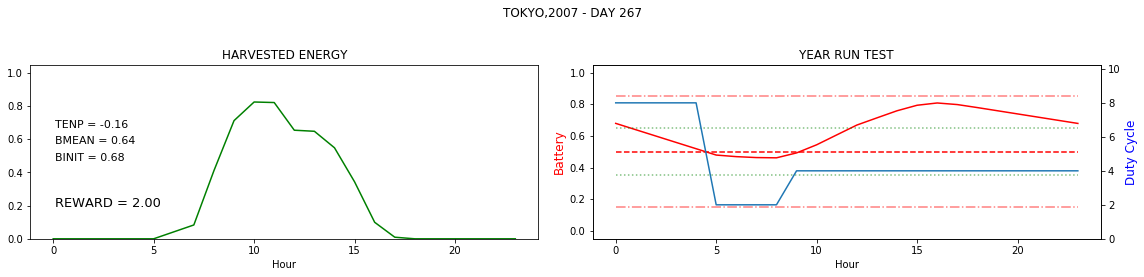

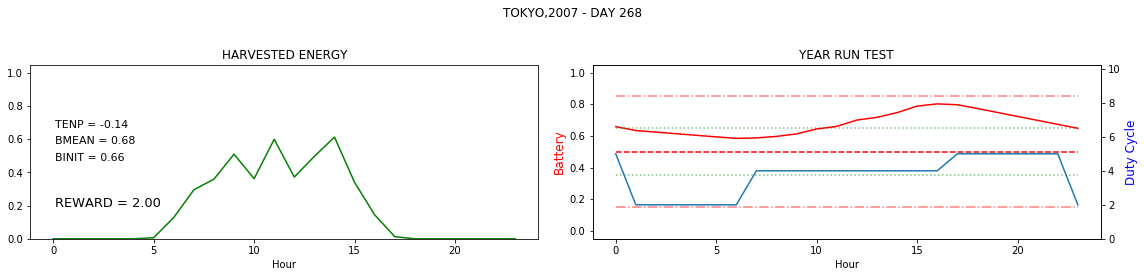

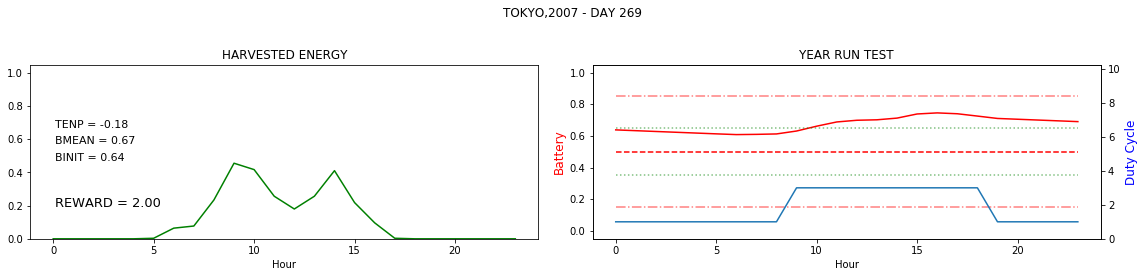

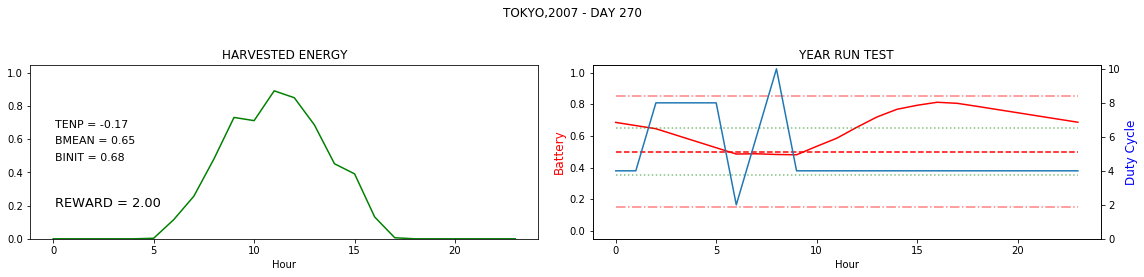

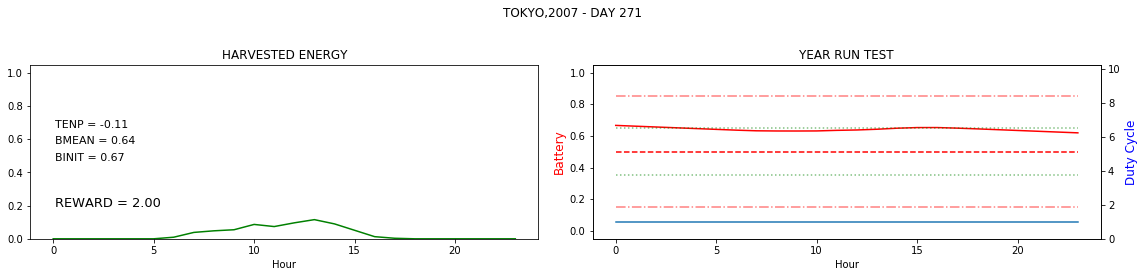

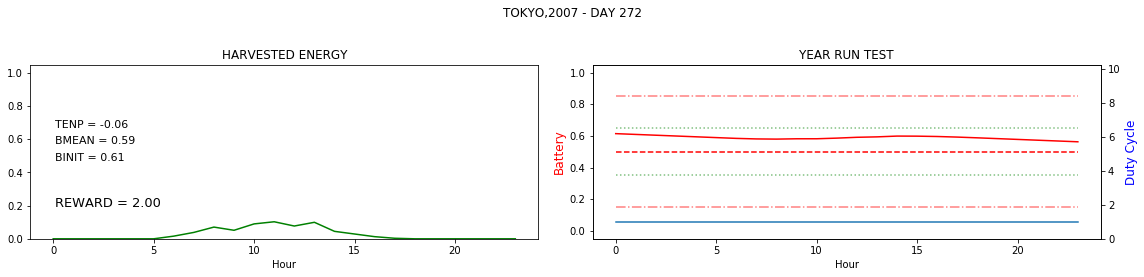

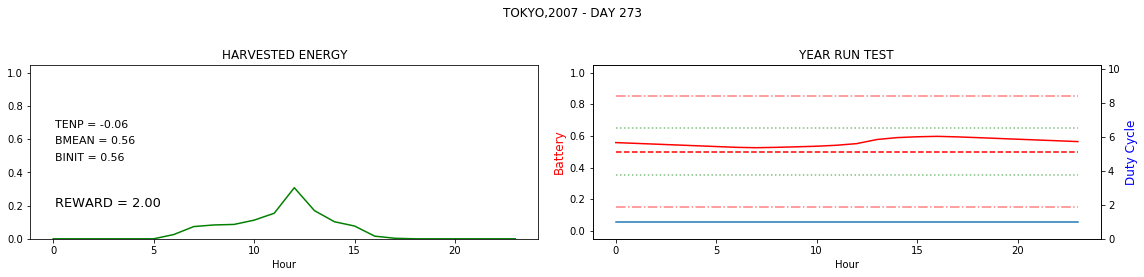

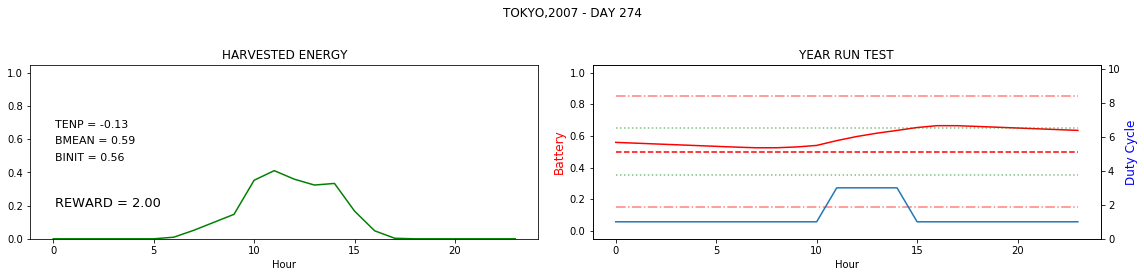

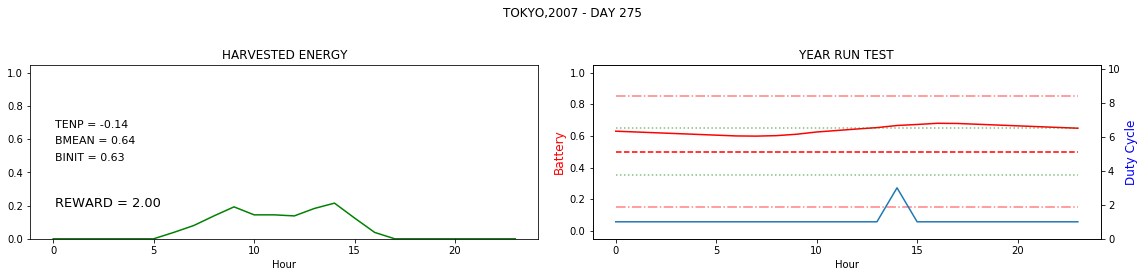

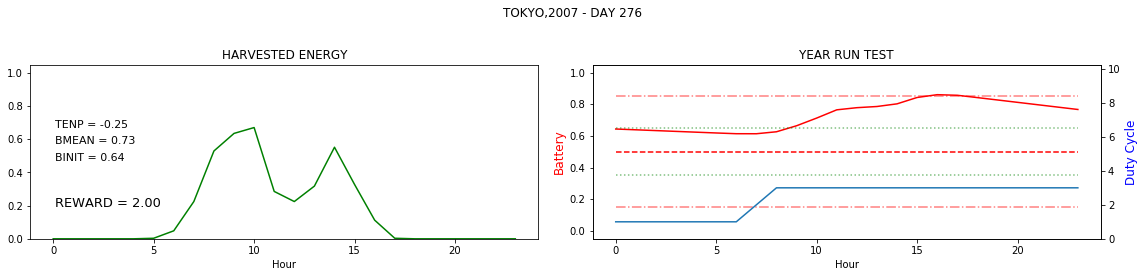

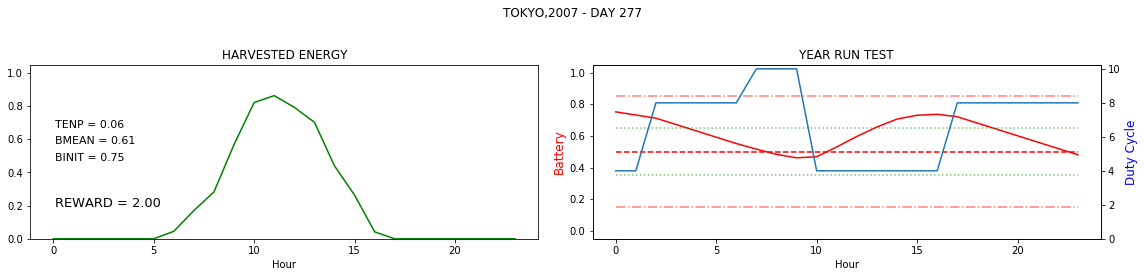

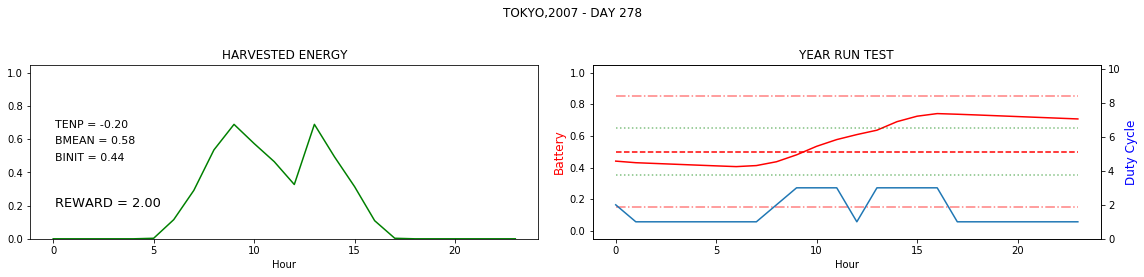

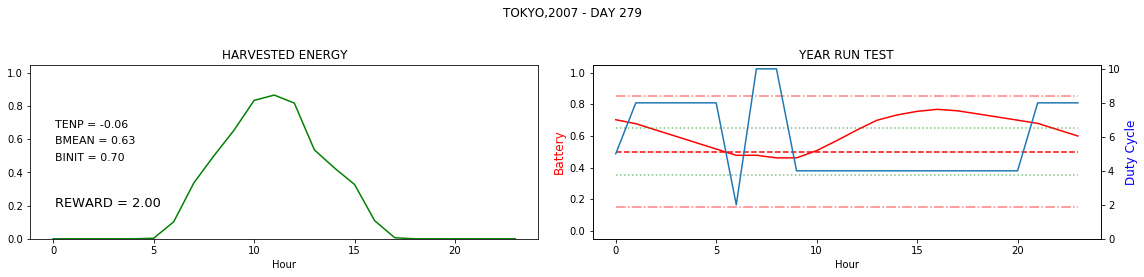

In [28]:
#Plot the reward and battery for the entire year run on a day by day basis
title = LOCATION.upper() + ',' + str(YEAR)
TIME_AXIS = np.arange(0,capm.eno.TIME_STEPS)
for DAY in range(DAY_START,DAY_END):
    START = DAY*24
    END = START+24

    daytitle = title + ' - DAY ' + str(DAY)
    fig = plt.figure(figsize=(16,4))
    st = fig.suptitle(daytitle)

    ax2 = fig.add_subplot(121)
    ax2.plot(yr_test_record[START:END,1],'g')
    ax2.set_title("HARVESTED ENERGY")
    ax2.set_xlabel("Hour")
    ax2.set_ylim([0,1.05])
    
    ax2.text(0.1, 0.6, "TENP = %.2f\n" %(capm.BOPT/capm.BMAX-yr_test_record[END,0]),fontsize=11, ha='left')
    ax2.text(0.1, 0.5, "BMEAN = %.2f\n" %(np.mean(yr_test_record[START:END,0])),fontsize=11, ha='left')
    ax2.text(0.1, 0.4, "BINIT = %.2f\n" %(yr_test_record[START,0]),fontsize=11, ha='left')
    if END < (capm.eno.NO_OF_DAYS*capm.eno.TIME_STEPS):
        ax2.text(0.1, 0.1, "REWARD = %.2f\n" %(yr_test_record[END,2]),fontsize=13, ha='left')
        
    #plot battery for year run
    ax1 = fig.add_subplot(122)
    ax1.plot(TIME_AXIS,              yr_test_record[START:END,0],'r')
    ax1.plot(TIME_AXIS, np.ones_like(yr_test_record[START:END,0])*capm.BOPT/capm.BMAX, 'r--')
    ax1.plot(TIME_AXIS, np.ones_like(yr_test_record[START:END,0])*capm.BLIM_LO/capm.BMAX, 'r-.',alpha=0.5)
    ax1.plot(TIME_AXIS, np.ones_like(yr_test_record[START:END,0])*capm.BLIM_HI/capm.BMAX, 'r-.',alpha=0.5)
    ax1.plot(TIME_AXIS, np.ones_like(yr_test_record[START:END,0])*(capm.BOPT+capm.ENP_MARGIN /2) /capm.BMAX, 'g:',alpha=0.5)
    ax1.plot(TIME_AXIS, np.ones_like(yr_test_record[START:END,0])*(capm.BOPT-capm.ENP_MARGIN/2)/capm.BMAX, 'g:',alpha=0.5)
    
    ax1.set_title("YEAR RUN TEST")
    ax1.set_xlabel("Hour")
    ax1.set_ylabel('Battery', color='r',fontsize=12)
    ax1.set_ylim([-0.05,1.05])

    #plot actions for year run
    ax1a = ax1.twinx()
    ax1a.plot(yr_test_record[START:END,3]+1)
    ax1a.set_ylim([0,N_ACTIONS])
    ax1a.set_ylabel('Duty Cycle', color='b',fontsize=12)
    ax1a.set_ylim([0,10.25])


    fig.tight_layout()
    st.set_y(0.95)
    fig.subplots_adjust(top=0.75)
    plt.show()

In [29]:
Q_TABLE.max(), Q_TABLE.min(), Q_TABLE.mean(), Q_TABLE.std()

(16.690596, -39.47196, 3.8107574, 7.325076)